In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import matplotlib as mpl

import numpy as np
import numpy.linalg as la

import time
import glob,os

# import torch
# from torch import nn
# from torch import optim
# import torch.nn.functional as F
# from torchvision import datasets, transforms, models
# from torch.autograd import Variable
# from sklearn.manifold import TSNE
from PIL import Image
from imageio import imread

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)

In [3]:
data_dir ='./results/'


## loading data

In [5]:
# labels
L = np.load(data_dir + "/L.npy")
# data from torch
tor_data = np.load(data_dir+ "/tor_data.npy")
# data after tsne
X_embedded = np.load(data_dir + "/X_embedded.npy")
#square difference from the center
SE = np.load(data_dir+ "/SE.npy")

subgroup_hier= np.load(data_dir+ "/subgroup_hier.npy", allow_pickle=True)

### load k-mean results

In [6]:
U = np.load(data_dir+"k_mean_15classes.npy",allow_pickle=True)
cl = U.item().get("cl")
c =  U.item().get("c")
k =  U.item().get("k")

In [7]:
### print out k-mean results

In [8]:
text = ''
array_text = []
for i in range(k):
#     print("group%d:"%i, np.array(L)[np.where(cl.numpy()==i)])
#     print(str(np.array(L)[np.where(cl.numpy()==i)]))
    text += "group%d:"%i + str(np.array(L)[np.where(cl.numpy()==i)]) +'\r\n'
    array_text.append(np.array(L)[np.where(cl.numpy()==i)])



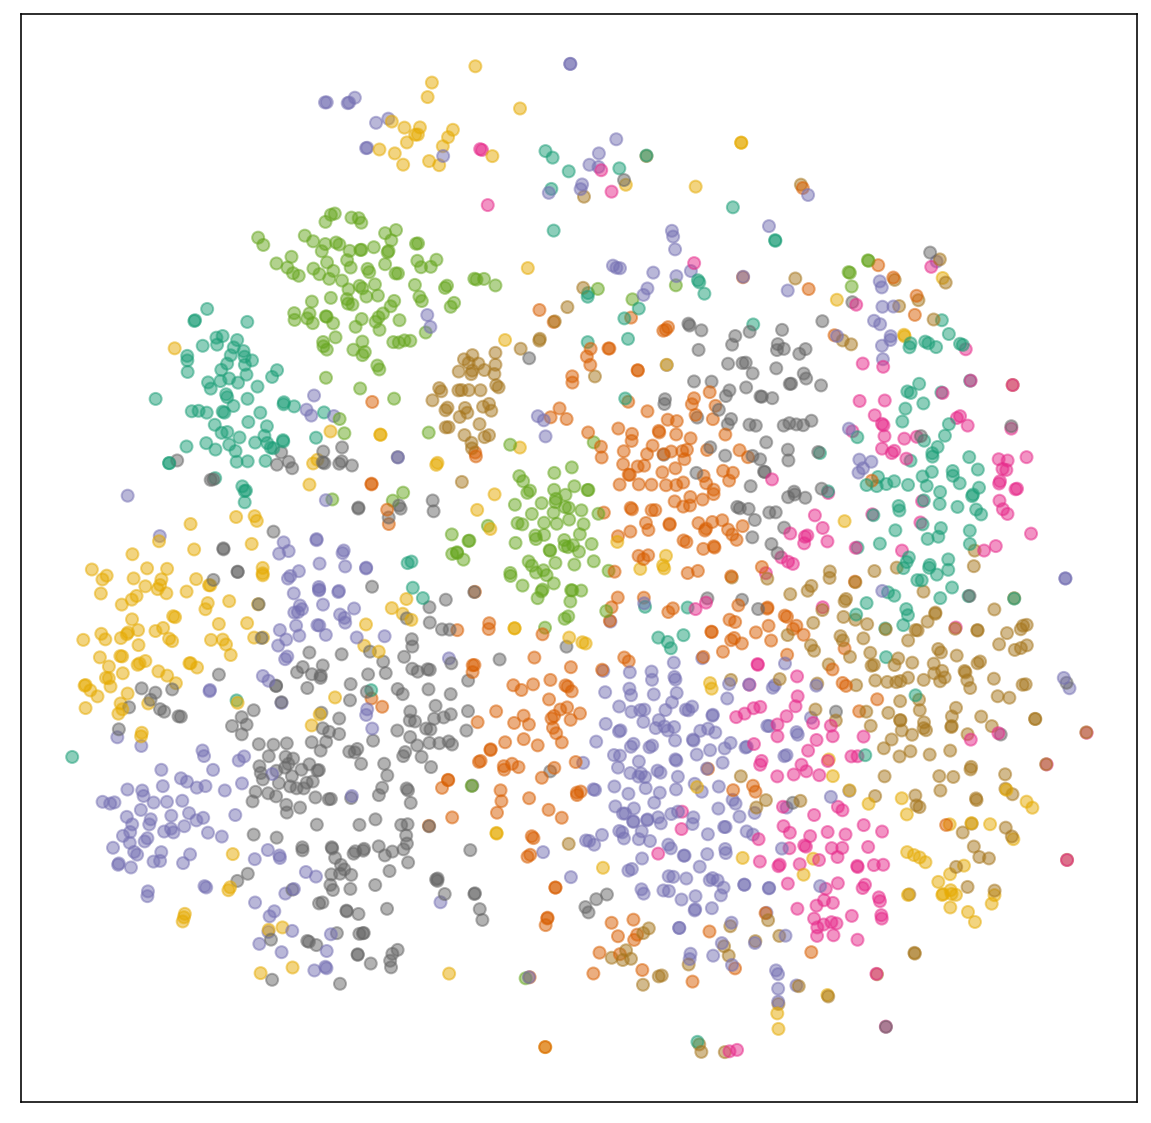

In [11]:
fig = plt.figure(figsize=(10,10))
cmap = plt.cm.get_cmap("Dark2", k)
ax = fig.add_subplot(111)
ax.scatter(X_embedded[:,0], X_embedded[:,1], 
           c = cmap(cl.cpu().numpy()), alpha = 0.5)
cmap = plt.cm.get_cmap("Dark2", k)
# for i in range(len(X_embedded[:,0])):
   
#     if i%5==0:
#         ax.text(X_embedded[i,0], X_embedded[i,1],
#                  L[i], color = cmap(cl.cpu()[i].numpy()),
#                  size = 14, alpha = 0.8)

plt.xticks([],[])
plt.yticks([],[])
plt.show()
# plt.savefig(data_saving_path + "/cluster_results_Tsn_k_%d.png"%k)

# Putting meaning into the node in graph

In [14]:
import pinyin
import pinyin.cedict
import textwrap
print(pinyin.get(L[0]))
s = str(pinyin.cedict.translate_word(L[0]))
print(textwrap.fill(s,25))

jiǒng
['variant of 冏[jiong3]',
'used as emoticon
("smiley") meaning
embarrassed, sad :-(,
depressed or frustrated']


In [15]:
defs = []
ps = []
nones = 0
filterL = []
for i in range(len(L)):
    
    s = str(pinyin.cedict.translate_word(L[i]))
    definition = textwrap.fill(s,35)   
    
    if definition == 'None':
        nones += 1
    else:
        filterL.append(i)
    
        Pinyin = str(pinyin.get(L[i]))
        defs.append(definition)
        ps.append(Pinyin)


# Plot using Bokeh

In [16]:
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, Plot, ColorBar, OpenURL, TapTool, CustomJS,Range1d,  Label
from bokeh.plotting import figure, save
from bokeh.models.glyphs import ImageURL
from bokeh.layouts import row

from random import random
from bokeh.models import CustomJS, ColumnDataSource, Row, Column
from bokeh.plotting import figure, show, curdoc
from bokeh.models.widgets import Button, TableColumn, Div,DataTable,TextInput


In [20]:
den_add = "./image/dengrograms"
colors = cl.cpu()[filterL].tolist()
files = [den_add +'/group_%d.png'%i for i in colors]

In [19]:
TOOLTIPS = """     
    <div> 
        <div>
            <span style="font-size: 17px; font-weight: bold;">@desc</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
        <div>
            <span style="font-size: 15px;">Pinyin:</span>
            <span style="font-size: 15px; color: #696;">(@pinyin)</span>
        </div>
        <div>
            <span style="font-size: 15px;">Class</span>
            <span style="font-size: 15px; color: #696;">(@colors)</span>
            
        </div>
        <div>
            <span style="font-size: 15px;">Def</span>
            <span style="font-size: 10px;white-space: pre-line">(@meaning)</span>
        </div>     
               
    </div>
"""

In [25]:
subgroup_hier_array =[]
for i in range(15):
    subgroup_hier_array.append(np.array(subgroup_hier.item()[i]))

In [28]:

classes = colors.copy()
print(max(colors))
mapper = linear_cmap(field_name='colors', palette=Category20[max(colors)] ,low=min(colors) ,high=max(colors))

# output_file("plot1.html")

s1 = ColumnDataSource(data=dict(
    x=X_embedded[:,0][filterL],
    y=X_embedded[:,1][filterL],
    desc=np.array(L)[filterL].tolist(),
    
    colors = colors,
    meaning = defs,
    pinyin = ps,
    sizes = list(np.max(SE)-np.array(SE)[filterL]),
    classes = classes,
    images_files = files,
   
))

p = figure(plot_width=650, plot_height=500, tooltips=TOOLTIPS, tools="tap", toolbar_location="above",
           title="Cluster of Chinese characters (k-means visualized by t-SNE)")

p.circle('x', 'y', size = 'sizes', fill_color=mapper, line_color=None, fill_alpha=0.75, source=s1)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))

p.add_layout(color_bar, 'right')

s2 = ColumnDataSource(data=dict(x=[], y=[], images_files = []))
p2 = figure(plot_width=400, plot_height=400,  x_range=(-50, 50), y_range=(-50, 50), \
            title="viewing words within the same class")

p2.image_url(url="images_files", source = s2, x=-60, y=60, w=120, h=120)

s1.selected.js_on_change('indices', CustomJS(args=dict(s1=s1, s2=s2), code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        d2['images_files'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
        d2['images_files'].push(d1['images_files'][inds[0]])
        }
        s2.change.emit();
    """)
)

data = dict(
        classes=range(15),
        words=subgroup_hier_array,
        num = [len(array_text[i]) for i in range(15)]
    )
source = ColumnDataSource(data)

columns = [
        TableColumn(field="num", title="# of characters",width=10),
        TableColumn(field="words", title="characters in each class with subclasses"),
    ]

data_table = DataTable(source=source, columns=columns, width=1200, height=500)



cb_click = CustomJS(args=dict(s1=s1), code="""
    var user_input = cb_obj.get('value')
    var d1 = s1.data
    desc = d1['desc']
    
    for (var i = 0; i < d1['x'].length; i++) {
        if(desc[i] == user_input) {
            var idx = i;
            break;
           } 
        }
        
    l_selected = s1.selected
    l_selected['1d'].indices = idx
    s1.selected = l_selected
    s1.change.emit()
    """)


text_input = TextInput(value="吴", title="Search character here:",callback = cb_click)
#p.add_tools(TapTool(callback=cb_click))    
    
layout = Column(text_input, row(p, p2), data_table)
# save(layout)
show(layout)

# show(p)


14


In [420]:
print([len(array_text[i]) for i in range(15)])

[89, 106, 143, 110, 225, 161, 160, 79, 115, 142, 64, 190, 39, 83, 244]
